###Import libraries

---



In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as scheduler
import datetime
import IPython
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive')

###Download test and train files

In [ ]:
!pip install kaggle --upgrade -q
%env KAGGLE_USERNAME=shankhinbrahmavar
%env KAGGLE_KEY=aefdd0d58d831be445ba8ebcf91bf723
!kaggle competitions download -c ecse-551-f21-mini-project-3

env: KAGGLE_USERNAME=shankhinbrahmavar
env: KAGGLE_KEY=aefdd0d58d831be445ba8ebcf91bf723
  0% 0.00/77.1k [00:00<?, ?B/s]
100% 77.1k/77.1k [00:00<00:00, 69.9MB/s]
100% 4.03M/4.03M [00:00<00:00, 41.1MB/s]

  0% 0.00/517k [00:00<?, ?B/s]
100% 517k/517k [00:00<00:00, 160MB/s]
  0% 0.00/517 [00:00<?, ?B/s]
100% 517/517 [00:00<00:00, 453kB/s]
  0% 0.00/49.9k [00:00<?, ?B/s]
100% 49.9k/49.9k [00:00<00:00, 51.2MB/s]
 37% 9.00M/24.1M [00:00<00:00, 33.9MB/s]
100% 24.1M/24.1M [00:00<00:00, 61.0MB/s]


In [ ]:
!unzip -o -q '*.zip' 
!rm *.zip
train_images = pickle.load(open('/content/Train.pkl', 'rb'))
train_labels = np.genfromtxt('/content/Train_labels.csv', delimiter=',', skip_header=1)[:,1:]
train_labels = train_labels[np.logical_not(np.isnan(train_labels))]
test_images = pickle.load(open('/content/Test.pkl', 'rb'))


2 archives were successfully processed.


###Visualize data


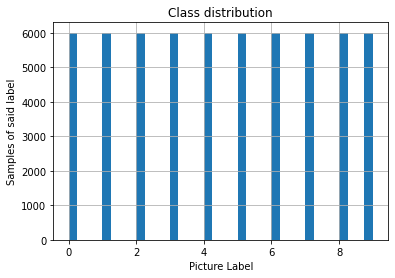

In [ ]:
plt.hist(train_labels, bins='auto')
plt.title("Class distribution")
plt.ylabel("Samples of said label")
plt.xlabel("Picture Label")
plt.grid()
plt.show()

###Implement transformation and dataset function

In [ ]:
# train_images1 = np.where(train_images >= 0.3, 1.0, 0.0)
mean, std = np.mean(train_images), np.std(train_images)
image_transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((mean,), (std,)),
                      transforms.RandomAffine(degrees = 15, shear = 20, fill = -0.5755)
                  ])

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None):
        self.data = img_file
        self.targets = label_file
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = np.expand_dims(np.squeeze(self.data[index]), axis = 2), int(self.targets[index])
        # img = np.where(img >= 0.5, 1.0, 0.0)
        if self.transform is not None:
           img = self.transform(img)
        img = img.float()
        img = img.to(device)
        target = torch.tensor(target).to(device)
        return img, target

###Split train data into training and validation data

In [ ]:
dataset = MyDataset(train_images, train_labels, transform = image_transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[48000,12000])

###Display a set of images

In [ ]:
def show_image(imgs):
    plt.imshow(imgs.cpu().numpy(), cmap='gray', vmin=-1, vmax=1) #.transpose()
    plt.show()

for i in range(10):
  imgs, labels = dataset[i]
  imgs = np.squeeze(imgs)
  imgs1 = train_images[i]
  imgs1 = np.squeeze(imgs1)
  show_image(imgs)
  plt.imshow(imgs1, cmap='gray', vmin=-1, vmax=1) #.transpose()
  plt.show()

###Divide dataset into batches using Dataloader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

###Define neural network class

In [ ]:
class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale).
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.m1 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3)
        self.m2 = nn.BatchNorm2d(256)

        # Now let us create some feed foreward layers in the end.
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)


    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
  def forward(self, x):
      
      # F.relu is ReLU activation. 
      x = F.relu(self.conv1(x), 2)
      x = F.relu(self.conv2(x), 2)
      x = F.relu(F.max_pool2d(self.conv3(x), 2))
      x = self.m1(x)      
      x = F.relu(self.conv4(x), 2)
      x = F.relu(self.conv5(x), 2)
      x = F.relu(F.max_pool2d(self.conv6(x), 2))
      x = self.m2(x)

      # This layer is an imaginary one.
      x = x.view(-1, 1024)

      # Feedforeward layers.
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)

      # We should put an appropriate activation for the output layer.
      return F.log_softmax(x)

###Define optimization function and learning rate decay function

In [ ]:
network = Net()
network.to(device)

optimizer = optim.AdamW(network.parameters(), lr = 0.001)
lr_scheduler = scheduler.ReduceLROnPlateau(optimizer)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

###Define train and test functions

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target) #negative log liklhood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 50 == 0:
      out.update(IPython.display.Pretty('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item())))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

path = '/content/gdrive/MyDrive/Colab Notebooks/Project 3/'
model_name = 'model1.pth'
def test(best_loss):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  if test_loss < best_loss or best_loss == 0:
    print('Saving new best model to {} \n'.format(path))
    torch.save(network.state_dict(), '{}{}'.format(path, model_name))
    torch.save(optimizer.state_dict(), '{}optimizer.pth'.format(path))
    return test_loss
  return best_loss

###Train until loss doesn't change over an interval

In [ ]:
print('Start training:', datetime.datetime.now())
patience = 100
counter = 0
epoch = 0
best_loss = 0

while(counter <= patience):
  out = display(IPython.display.Pretty(''), display_id=True)
  train(epoch)
  new_loss = test(best_loss)
  if new_loss <= best_loss or best_loss == 0:
    counter = 0
    best_loss = new_loss
  else:
      counter += 1
  lr_scheduler.step(new_loss)
  epoch += 1

Start training: 2021-12-10 18:07:08.372532


Train Epoch: 0 [47200/48000 (98%)]	Loss: 0.214243

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7512, Accuracy: 9938/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 1 [47200/48000 (98%)]	Loss: 0.376828


Test set: Avg. loss: 0.6584, Accuracy: 9946/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 2 [47200/48000 (98%)]	Loss: 0.985519


Test set: Avg. loss: 1.5991, Accuracy: 9909/12000 (83%)


Train Epoch: 3 [47200/48000 (98%)]	Loss: 0.438774


Test set: Avg. loss: 0.5071, Accuracy: 9952/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 4 [47200/48000 (98%)]	Loss: 0.439999


Test set: Avg. loss: 0.7511, Accuracy: 9957/12000 (83%)


Train Epoch: 5 [47200/48000 (98%)]	Loss: 0.337807


Test set: Avg. loss: 0.4827, Accuracy: 9937/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 6 [47200/48000 (98%)]	Loss: 0.406489


Test set: Avg. loss: 0.6026, Accuracy: 9950/12000 (83%)


Train Epoch: 7 [47200/48000 (98%)]	Loss: 0.461819


Test set: Avg. loss: 0.5783, Accuracy: 9981/12000 (83%)


Train Epoch: 8 [47200/48000 (98%)]	Loss: 0.348433


Test set: Avg. loss: 0.4975, Accuracy: 9988/12000 (83%)


Train Epoch: 9 [47200/48000 (98%)]	Loss: 0.225435


Test set: Avg. loss: 0.5857, Accuracy: 9912/12000 (83%)


Train Epoch: 10 [47200/48000 (98%)]	Loss: 0.496766


Test set: Avg. loss: 0.5280, Accuracy: 9988/12000 (83%)


Train Epoch: 11 [47200/48000 (98%)]	Loss: 0.453701


Test set: Avg. loss: 1.5033, Accuracy: 9976/12000 (83%)


Train Epoch: 12 [47200/48000 (98%)]	Loss: 0.137373


Test set: Avg. loss: 0.5431, Accuracy: 9940/12000 (83%)


Train Epoch: 13 [47200/48000 (98%)]	Loss: 0.392075


Test set: Avg. loss: 1.4353, Accuracy: 9959/12000 (83%)


Train Epoch: 14 [47200/48000 (98%)]	Loss: 0.233518


Test set: Avg. loss: 0.5005, Accuracy: 9952/12000 (83%)


Train Epoch: 15 [47200/48000 (98%)]	Loss: 0.915540


Test set: Avg. loss: 0.4734, Accuracy: 9933/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 16 [47200/48000 (98%)]	Loss: 0.472108


Test set: Avg. loss: 0.4800, Accuracy: 9986/12000 (83%)


Train Epoch: 17 [47200/48000 (98%)]	Loss: 0.364424


Test set: Avg. loss: 0.6264, Accuracy: 9975/12000 (83%)


Train Epoch: 18 [47200/48000 (98%)]	Loss: 0.195305


Test set: Avg. loss: 0.4776, Accuracy: 9986/12000 (83%)


Train Epoch: 19 [47200/48000 (98%)]	Loss: 0.290337


Test set: Avg. loss: 1.3388, Accuracy: 9993/12000 (83%)


Train Epoch: 20 [47200/48000 (98%)]	Loss: 0.396629


Test set: Avg. loss: 0.4968, Accuracy: 9954/12000 (83%)


Train Epoch: 21 [47200/48000 (98%)]	Loss: 0.448914


Test set: Avg. loss: 0.5176, Accuracy: 9948/12000 (83%)


Train Epoch: 22 [47200/48000 (98%)]	Loss: 0.430134


Test set: Avg. loss: 0.8281, Accuracy: 9920/12000 (83%)


Train Epoch: 23 [47200/48000 (98%)]	Loss: 0.519215


Test set: Avg. loss: 0.7667, Accuracy: 9993/12000 (83%)


Train Epoch: 24 [47200/48000 (98%)]	Loss: 0.696470


Test set: Avg. loss: 0.6216, Accuracy: 9979/12000 (83%)


Train Epoch: 25 [47200/48000 (98%)]	Loss: 0.062962


Test set: Avg. loss: 0.5495, Accuracy: 9980/12000 (83%)


Train Epoch: 26 [47200/48000 (98%)]	Loss: 0.431497


Test set: Avg. loss: 0.4789, Accuracy: 9952/12000 (83%)


Train Epoch: 27 [47200/48000 (98%)]	Loss: 0.091825


Test set: Avg. loss: 0.4739, Accuracy: 9927/12000 (83%)


Train Epoch: 28 [47200/48000 (98%)]	Loss: 0.186289


Test set: Avg. loss: 2.5072, Accuracy: 9908/12000 (83%)


Train Epoch: 29 [47200/48000 (98%)]	Loss: 0.448005


Test set: Avg. loss: 1.8423, Accuracy: 9957/12000 (83%)


Train Epoch: 30 [47200/48000 (98%)]	Loss: 0.580130


Test set: Avg. loss: 1.2658, Accuracy: 9966/12000 (83%)


Train Epoch: 31 [47200/48000 (98%)]	Loss: 0.771409


Test set: Avg. loss: 0.5128, Accuracy: 9976/12000 (83%)


Train Epoch: 32 [47200/48000 (98%)]	Loss: 0.192658


Test set: Avg. loss: 0.4747, Accuracy: 9974/12000 (83%)


Train Epoch: 33 [47200/48000 (98%)]	Loss: 0.659801


Test set: Avg. loss: 1.9595, Accuracy: 9938/12000 (83%)


Train Epoch: 34 [47200/48000 (98%)]	Loss: 0.511863


Test set: Avg. loss: 2.0746, Accuracy: 9954/12000 (83%)


Train Epoch: 35 [47200/48000 (98%)]	Loss: 0.502076


Test set: Avg. loss: 1.3670, Accuracy: 9952/12000 (83%)


Train Epoch: 36 [47200/48000 (98%)]	Loss: 0.368123


Test set: Avg. loss: 0.5537, Accuracy: 9957/12000 (83%)


Train Epoch: 37 [47200/48000 (98%)]	Loss: 0.288396


Test set: Avg. loss: 1.0495, Accuracy: 9927/12000 (83%)


Train Epoch: 38 [47200/48000 (98%)]	Loss: 0.126399


Test set: Avg. loss: 1.8192, Accuracy: 9911/12000 (83%)


Train Epoch: 39 [47200/48000 (98%)]	Loss: 0.122128


Test set: Avg. loss: 0.4699, Accuracy: 9946/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 40 [47200/48000 (98%)]	Loss: 0.191955


Test set: Avg. loss: 1.3739, Accuracy: 9949/12000 (83%)


Train Epoch: 41 [47200/48000 (98%)]	Loss: 0.376284


Test set: Avg. loss: 1.3536, Accuracy: 9907/12000 (83%)


Train Epoch: 42 [47200/48000 (98%)]	Loss: 0.271864


Test set: Avg. loss: 0.8401, Accuracy: 9956/12000 (83%)


Train Epoch: 43 [47200/48000 (98%)]	Loss: 0.286004


Test set: Avg. loss: 0.5177, Accuracy: 9947/12000 (83%)


Train Epoch: 44 [47200/48000 (98%)]	Loss: 0.368859


Test set: Avg. loss: 1.5212, Accuracy: 9945/12000 (83%)


Train Epoch: 45 [47200/48000 (98%)]	Loss: 0.366123


Test set: Avg. loss: 0.4804, Accuracy: 9929/12000 (83%)


Train Epoch: 46 [47200/48000 (98%)]	Loss: 0.630376


Test set: Avg. loss: 0.6502, Accuracy: 9912/12000 (83%)


Train Epoch: 47 [47200/48000 (98%)]	Loss: 0.585818


Test set: Avg. loss: 1.0987, Accuracy: 9924/12000 (83%)


Train Epoch: 48 [47200/48000 (98%)]	Loss: 0.518231


Test set: Avg. loss: 0.8726, Accuracy: 9899/12000 (82%)


Train Epoch: 49 [47200/48000 (98%)]	Loss: 0.594180


Test set: Avg. loss: 2.2946, Accuracy: 9901/12000 (83%)


Train Epoch: 50 [47200/48000 (98%)]	Loss: 0.287492


Test set: Avg. loss: 0.5397, Accuracy: 9959/12000 (83%)


Train Epoch: 51 [47200/48000 (98%)]	Loss: 0.495246


Test set: Avg. loss: 0.4666, Accuracy: 10010/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 52 [47200/48000 (98%)]	Loss: 0.127939


Test set: Avg. loss: 1.2326, Accuracy: 9901/12000 (83%)


Train Epoch: 53 [47200/48000 (98%)]	Loss: 0.188680


Test set: Avg. loss: 0.4901, Accuracy: 9973/12000 (83%)


Train Epoch: 54 [47200/48000 (98%)]	Loss: 0.198936


Test set: Avg. loss: 0.5729, Accuracy: 9941/12000 (83%)


Train Epoch: 55 [47200/48000 (98%)]	Loss: 0.361349


Test set: Avg. loss: 2.2683, Accuracy: 9947/12000 (83%)


Train Epoch: 56 [47200/48000 (98%)]	Loss: 0.185870


Test set: Avg. loss: 0.4787, Accuracy: 9967/12000 (83%)


Train Epoch: 57 [47200/48000 (98%)]	Loss: 0.291319


Test set: Avg. loss: 0.4942, Accuracy: 9941/12000 (83%)


Train Epoch: 58 [47200/48000 (98%)]	Loss: 0.421532


Test set: Avg. loss: 0.5229, Accuracy: 9953/12000 (83%)


Train Epoch: 59 [47200/48000 (98%)]	Loss: 0.180740


Test set: Avg. loss: 0.4746, Accuracy: 9950/12000 (83%)


Train Epoch: 60 [47200/48000 (98%)]	Loss: 0.368870


Test set: Avg. loss: 0.5930, Accuracy: 9955/12000 (83%)


Train Epoch: 61 [47200/48000 (98%)]	Loss: 0.113600


Test set: Avg. loss: 2.0006, Accuracy: 9986/12000 (83%)


Train Epoch: 62 [47200/48000 (98%)]	Loss: 0.285662


Test set: Avg. loss: 1.5877, Accuracy: 9982/12000 (83%)


Train Epoch: 63 [47200/48000 (98%)]	Loss: 0.711310


Test set: Avg. loss: 0.5290, Accuracy: 9927/12000 (83%)


Train Epoch: 64 [47200/48000 (98%)]	Loss: 0.485109


Test set: Avg. loss: 0.5135, Accuracy: 9935/12000 (83%)


Train Epoch: 65 [47200/48000 (98%)]	Loss: 0.303491


Test set: Avg. loss: 1.4907, Accuracy: 9955/12000 (83%)


Train Epoch: 66 [47200/48000 (98%)]	Loss: 0.234562


Test set: Avg. loss: 0.5256, Accuracy: 9924/12000 (83%)


Train Epoch: 67 [47200/48000 (98%)]	Loss: 0.693566


Test set: Avg. loss: 1.8392, Accuracy: 9971/12000 (83%)


Train Epoch: 68 [47200/48000 (98%)]	Loss: 0.095542


Test set: Avg. loss: 0.5561, Accuracy: 9989/12000 (83%)


Train Epoch: 69 [47200/48000 (98%)]	Loss: 0.150477


Test set: Avg. loss: 0.6080, Accuracy: 9905/12000 (83%)


Train Epoch: 70 [47200/48000 (98%)]	Loss: 0.484803


Test set: Avg. loss: 1.2803, Accuracy: 9955/12000 (83%)


Train Epoch: 71 [47200/48000 (98%)]	Loss: 0.707380


Test set: Avg. loss: 0.4818, Accuracy: 9982/12000 (83%)


Train Epoch: 72 [47200/48000 (98%)]	Loss: 0.072057


Test set: Avg. loss: 0.5717, Accuracy: 9995/12000 (83%)


Train Epoch: 73 [47200/48000 (98%)]	Loss: 0.278360


Test set: Avg. loss: 0.5261, Accuracy: 9973/12000 (83%)


Train Epoch: 74 [47200/48000 (98%)]	Loss: 0.369625


Test set: Avg. loss: 0.4736, Accuracy: 9986/12000 (83%)


Train Epoch: 75 [47200/48000 (98%)]	Loss: 0.297310


Test set: Avg. loss: 0.4867, Accuracy: 9974/12000 (83%)


Train Epoch: 76 [47200/48000 (98%)]	Loss: 0.406080


Test set: Avg. loss: 1.1303, Accuracy: 9957/12000 (83%)


Train Epoch: 77 [47200/48000 (98%)]	Loss: 0.354471


Test set: Avg. loss: 0.5037, Accuracy: 9972/12000 (83%)


Train Epoch: 78 [47200/48000 (98%)]	Loss: 0.158735


Test set: Avg. loss: 0.5150, Accuracy: 10004/12000 (83%)


Train Epoch: 79 [47200/48000 (98%)]	Loss: 0.356509


Test set: Avg. loss: 0.5623, Accuracy: 9934/12000 (83%)


Train Epoch: 80 [47200/48000 (98%)]	Loss: 0.120034


Test set: Avg. loss: 0.4899, Accuracy: 9944/12000 (83%)


Train Epoch: 81 [47200/48000 (98%)]	Loss: 0.603536


Test set: Avg. loss: 0.4854, Accuracy: 9971/12000 (83%)


Train Epoch: 82 [47200/48000 (98%)]	Loss: 0.377109


Test set: Avg. loss: 0.4722, Accuracy: 9973/12000 (83%)


Train Epoch: 83 [47200/48000 (98%)]	Loss: 0.720278


Test set: Avg. loss: 0.8482, Accuracy: 9944/12000 (83%)


Train Epoch: 84 [47200/48000 (98%)]	Loss: 0.294697


Test set: Avg. loss: 1.6214, Accuracy: 9947/12000 (83%)


Train Epoch: 85 [47200/48000 (98%)]	Loss: 0.373991


Test set: Avg. loss: 1.5767, Accuracy: 9955/12000 (83%)


Train Epoch: 86 [47200/48000 (98%)]	Loss: 0.253942


Test set: Avg. loss: 0.4667, Accuracy: 9990/12000 (83%)


Train Epoch: 87 [47200/48000 (98%)]	Loss: 0.789778


Test set: Avg. loss: 1.7677, Accuracy: 9954/12000 (83%)


Train Epoch: 88 [47200/48000 (98%)]	Loss: 0.402579


Test set: Avg. loss: 1.9949, Accuracy: 9925/12000 (83%)


Train Epoch: 89 [47200/48000 (98%)]	Loss: 0.475449


Test set: Avg. loss: 0.7220, Accuracy: 9959/12000 (83%)


Train Epoch: 90 [47200/48000 (98%)]	Loss: 0.458385


Test set: Avg. loss: 2.1048, Accuracy: 9968/12000 (83%)


Train Epoch: 91 [47200/48000 (98%)]	Loss: 0.196576


Test set: Avg. loss: 0.8013, Accuracy: 9933/12000 (83%)


Train Epoch: 92 [47200/48000 (98%)]	Loss: 0.299856


Test set: Avg. loss: 1.5341, Accuracy: 10013/12000 (83%)


Train Epoch: 93 [47200/48000 (98%)]	Loss: 0.200818


Test set: Avg. loss: 1.4704, Accuracy: 9926/12000 (83%)


Train Epoch: 94 [47200/48000 (98%)]	Loss: 0.283356


Test set: Avg. loss: 0.4645, Accuracy: 10005/12000 (83%)
Saving new best model to /content/gdrive/MyDrive/Colab Notebooks/Project 3/ 



Train Epoch: 95 [47200/48000 (98%)]	Loss: 0.319683


Test set: Avg. loss: 0.6774, Accuracy: 9944/12000 (83%)


Train Epoch: 96 [47200/48000 (98%)]	Loss: 0.180396


Test set: Avg. loss: 0.7944, Accuracy: 9914/12000 (83%)


Train Epoch: 97 [47200/48000 (98%)]	Loss: 0.174315


Test set: Avg. loss: 0.7172, Accuracy: 9931/12000 (83%)


Train Epoch: 98 [47200/48000 (98%)]	Loss: 0.163470


Test set: Avg. loss: 1.9565, Accuracy: 9923/12000 (83%)


Train Epoch: 99 [47200/48000 (98%)]	Loss: 0.514631


Test set: Avg. loss: 0.7081, Accuracy: 9929/12000 (83%)


Train Epoch: 100 [47200/48000 (98%)]	Loss: 0.049640


Test set: Avg. loss: 1.3788, Accuracy: 9975/12000 (83%)


Train Epoch: 101 [47200/48000 (98%)]	Loss: 0.218906


Test set: Avg. loss: 0.4804, Accuracy: 9969/12000 (83%)


Train Epoch: 102 [47200/48000 (98%)]	Loss: 0.284870


Test set: Avg. loss: 2.4946, Accuracy: 9935/12000 (83%)


Train Epoch: 103 [47200/48000 (98%)]	Loss: 0.537038


Test set: Avg. loss: 0.5043, Accuracy: 9915/12000 (83%)


Train Epoch: 104 [47200/48000 (98%)]	Loss: 0.617064


Test set: Avg. loss: 0.4737, Accuracy: 9947/12000 (83%)


Train Epoch: 105 [47200/48000 (98%)]	Loss: 0.314712


Test set: Avg. loss: 0.4720, Accuracy: 9948/12000 (83%)


Train Epoch: 106 [47200/48000 (98%)]	Loss: 0.638919


Test set: Avg. loss: 1.6164, Accuracy: 9920/12000 (83%)


Train Epoch: 107 [47200/48000 (98%)]	Loss: 0.541501


Test set: Avg. loss: 0.5131, Accuracy: 9962/12000 (83%)


Train Epoch: 108 [47200/48000 (98%)]	Loss: 0.088298


Test set: Avg. loss: 0.5379, Accuracy: 9996/12000 (83%)


Train Epoch: 109 [47200/48000 (98%)]	Loss: 0.274671


Test set: Avg. loss: 0.4896, Accuracy: 9984/12000 (83%)


Train Epoch: 110 [47200/48000 (98%)]	Loss: 0.186024


Test set: Avg. loss: 0.5850, Accuracy: 9964/12000 (83%)


Train Epoch: 111 [47200/48000 (98%)]	Loss: 0.530255


Test set: Avg. loss: 0.4810, Accuracy: 9941/12000 (83%)


Train Epoch: 112 [47200/48000 (98%)]	Loss: 0.285219


Test set: Avg. loss: 2.9790, Accuracy: 9940/12000 (83%)


Train Epoch: 113 [47200/48000 (98%)]	Loss: 0.661618


Test set: Avg. loss: 0.4871, Accuracy: 9967/12000 (83%)


Train Epoch: 114 [47200/48000 (98%)]	Loss: 0.507594


Test set: Avg. loss: 0.5261, Accuracy: 9973/12000 (83%)


Train Epoch: 115 [47200/48000 (98%)]	Loss: 0.268396


Test set: Avg. loss: 0.4649, Accuracy: 9972/12000 (83%)


Train Epoch: 116 [47200/48000 (98%)]	Loss: 0.114832


Test set: Avg. loss: 0.4842, Accuracy: 9980/12000 (83%)


Train Epoch: 117 [47200/48000 (98%)]	Loss: 0.195851


Test set: Avg. loss: 0.4936, Accuracy: 9978/12000 (83%)


Train Epoch: 118 [47200/48000 (98%)]	Loss: 0.432588


Test set: Avg. loss: 2.5209, Accuracy: 9926/12000 (83%)


Train Epoch: 119 [47200/48000 (98%)]	Loss: 0.338130


Test set: Avg. loss: 1.6662, Accuracy: 9902/12000 (83%)


Train Epoch: 120 [47200/48000 (98%)]	Loss: 0.573041


Test set: Avg. loss: 0.5276, Accuracy: 9980/12000 (83%)


Train Epoch: 121 [47200/48000 (98%)]	Loss: 0.137834


Test set: Avg. loss: 0.5266, Accuracy: 9955/12000 (83%)


Train Epoch: 122 [47200/48000 (98%)]	Loss: 0.240668


Test set: Avg. loss: 0.5289, Accuracy: 9980/12000 (83%)


Train Epoch: 123 [47200/48000 (98%)]	Loss: 0.361913


Test set: Avg. loss: 0.4728, Accuracy: 9965/12000 (83%)


Train Epoch: 124 [47200/48000 (98%)]	Loss: 0.422950


Test set: Avg. loss: 0.5437, Accuracy: 9926/12000 (83%)


Train Epoch: 125 [47200/48000 (98%)]	Loss: 0.409155


Test set: Avg. loss: 0.8824, Accuracy: 9977/12000 (83%)


Train Epoch: 126 [47200/48000 (98%)]	Loss: 0.195579


Test set: Avg. loss: 1.7915, Accuracy: 9959/12000 (83%)


Train Epoch: 127 [47200/48000 (98%)]	Loss: 0.237222


Test set: Avg. loss: 0.4736, Accuracy: 9963/12000 (83%)


Train Epoch: 128 [47200/48000 (98%)]	Loss: 0.160163


Test set: Avg. loss: 0.7791, Accuracy: 9959/12000 (83%)


Train Epoch: 129 [47200/48000 (98%)]	Loss: 0.435748


Test set: Avg. loss: 0.5468, Accuracy: 9946/12000 (83%)


Train Epoch: 130 [47200/48000 (98%)]	Loss: 0.135315


Test set: Avg. loss: 0.4972, Accuracy: 9949/12000 (83%)


Train Epoch: 131 [47200/48000 (98%)]	Loss: 0.328540


Test set: Avg. loss: 0.5752, Accuracy: 9962/12000 (83%)


Train Epoch: 132 [47200/48000 (98%)]	Loss: 0.487388


Test set: Avg. loss: 0.7083, Accuracy: 9931/12000 (83%)


Train Epoch: 133 [47200/48000 (98%)]	Loss: 0.360508


Test set: Avg. loss: 0.5300, Accuracy: 9987/12000 (83%)


Train Epoch: 134 [47200/48000 (98%)]	Loss: 0.811448


Test set: Avg. loss: 0.4765, Accuracy: 9967/12000 (83%)


Train Epoch: 135 [47200/48000 (98%)]	Loss: 0.236011


Test set: Avg. loss: 0.4875, Accuracy: 9963/12000 (83%)


Train Epoch: 136 [47200/48000 (98%)]	Loss: 0.428624


Test set: Avg. loss: 0.6835, Accuracy: 9946/12000 (83%)


Train Epoch: 137 [47200/48000 (98%)]	Loss: 0.305963


Test set: Avg. loss: 2.7209, Accuracy: 9971/12000 (83%)


Train Epoch: 138 [47200/48000 (98%)]	Loss: 0.380996


Test set: Avg. loss: 2.4980, Accuracy: 9931/12000 (83%)


Train Epoch: 139 [47200/48000 (98%)]	Loss: 0.244379


Test set: Avg. loss: 0.7030, Accuracy: 9945/12000 (83%)


Train Epoch: 140 [47200/48000 (98%)]	Loss: 0.251716


Test set: Avg. loss: 0.4760, Accuracy: 9957/12000 (83%)


Train Epoch: 141 [47200/48000 (98%)]	Loss: 0.541493


Test set: Avg. loss: 0.4667, Accuracy: 10004/12000 (83%)


Train Epoch: 142 [47200/48000 (98%)]	Loss: 0.174099


Test set: Avg. loss: 0.5027, Accuracy: 9961/12000 (83%)


Train Epoch: 143 [47200/48000 (98%)]	Loss: 0.249684


Test set: Avg. loss: 0.5776, Accuracy: 9948/12000 (83%)


Train Epoch: 144 [47200/48000 (98%)]	Loss: 0.587018


Test set: Avg. loss: 1.0671, Accuracy: 9977/12000 (83%)


Train Epoch: 145 [47200/48000 (98%)]	Loss: 0.346320


Test set: Avg. loss: 0.4731, Accuracy: 9977/12000 (83%)


Train Epoch: 146 [47200/48000 (98%)]	Loss: 0.442726


Test set: Avg. loss: 1.6968, Accuracy: 9972/12000 (83%)


Train Epoch: 147 [47200/48000 (98%)]	Loss: 0.405862


Test set: Avg. loss: 0.5181, Accuracy: 9956/12000 (83%)


Train Epoch: 148 [47200/48000 (98%)]	Loss: 0.760271


Test set: Avg. loss: 0.5953, Accuracy: 9948/12000 (83%)


Train Epoch: 149 [47200/48000 (98%)]	Loss: 0.305064


Test set: Avg. loss: 0.6556, Accuracy: 9967/12000 (83%)


Train Epoch: 150 [47200/48000 (98%)]	Loss: 0.267242


Test set: Avg. loss: 1.6233, Accuracy: 9949/12000 (83%)


Train Epoch: 151 [47200/48000 (98%)]	Loss: 0.100774


Test set: Avg. loss: 2.3880, Accuracy: 9954/12000 (83%)


Train Epoch: 152 [47200/48000 (98%)]	Loss: 0.219258


Test set: Avg. loss: 0.5742, Accuracy: 9975/12000 (83%)


Train Epoch: 153 [47200/48000 (98%)]	Loss: 0.665714


Test set: Avg. loss: 2.2209, Accuracy: 9951/12000 (83%)


Train Epoch: 154 [47200/48000 (98%)]	Loss: 0.284661


Test set: Avg. loss: 0.8596, Accuracy: 9935/12000 (83%)


Train Epoch: 155 [47200/48000 (98%)]	Loss: 0.346240


Test set: Avg. loss: 1.2518, Accuracy: 9953/12000 (83%)


Train Epoch: 156 [47200/48000 (98%)]	Loss: 0.404719


Test set: Avg. loss: 0.4741, Accuracy: 9920/12000 (83%)


Train Epoch: 157 [47200/48000 (98%)]	Loss: 0.153662


Test set: Avg. loss: 2.5328, Accuracy: 9922/12000 (83%)


Train Epoch: 158 [47200/48000 (98%)]	Loss: 0.469318


Test set: Avg. loss: 0.4785, Accuracy: 9989/12000 (83%)


Train Epoch: 159 [47200/48000 (98%)]	Loss: 0.382155


Test set: Avg. loss: 0.6792, Accuracy: 9953/12000 (83%)


Train Epoch: 160 [47200/48000 (98%)]	Loss: 0.725050


Test set: Avg. loss: 0.4805, Accuracy: 9950/12000 (83%)


Train Epoch: 161 [47200/48000 (98%)]	Loss: 0.468712


Test set: Avg. loss: 1.5202, Accuracy: 9958/12000 (83%)


Train Epoch: 162 [47200/48000 (98%)]	Loss: 0.324820


Test set: Avg. loss: 1.7065, Accuracy: 9908/12000 (83%)


Train Epoch: 163 [47200/48000 (98%)]	Loss: 0.443261


Test set: Avg. loss: 0.5386, Accuracy: 10010/12000 (83%)


Train Epoch: 164 [47200/48000 (98%)]	Loss: 0.244852


Test set: Avg. loss: 0.6510, Accuracy: 9972/12000 (83%)


Train Epoch: 165 [47200/48000 (98%)]	Loss: 0.496507


Test set: Avg. loss: 1.4711, Accuracy: 9966/12000 (83%)


Train Epoch: 166 [47200/48000 (98%)]	Loss: 0.357261


Test set: Avg. loss: 0.4919, Accuracy: 9968/12000 (83%)


Train Epoch: 167 [47200/48000 (98%)]	Loss: 0.251910


Test set: Avg. loss: 0.8072, Accuracy: 9975/12000 (83%)


Train Epoch: 168 [47200/48000 (98%)]	Loss: 0.638772


Test set: Avg. loss: 1.8405, Accuracy: 9948/12000 (83%)


Train Epoch: 169 [47200/48000 (98%)]	Loss: 0.137153


Test set: Avg. loss: 1.4546, Accuracy: 9941/12000 (83%)


Train Epoch: 170 [47200/48000 (98%)]	Loss: 0.338613


Test set: Avg. loss: 0.4928, Accuracy: 9966/12000 (83%)


Train Epoch: 171 [47200/48000 (98%)]	Loss: 0.381782


Test set: Avg. loss: 1.8713, Accuracy: 9907/12000 (83%)


Train Epoch: 172 [47200/48000 (98%)]	Loss: 0.431807


Test set: Avg. loss: 0.4947, Accuracy: 9947/12000 (83%)


Train Epoch: 173 [47200/48000 (98%)]	Loss: 0.246446


Test set: Avg. loss: 1.3714, Accuracy: 9943/12000 (83%)


Train Epoch: 174 [47200/48000 (98%)]	Loss: 0.348167


Test set: Avg. loss: 0.6766, Accuracy: 9948/12000 (83%)


Train Epoch: 175 [47200/48000 (98%)]	Loss: 0.252134


Test set: Avg. loss: 2.4631, Accuracy: 9928/12000 (83%)


Train Epoch: 176 [47200/48000 (98%)]	Loss: 0.332339


Test set: Avg. loss: 1.6925, Accuracy: 9900/12000 (82%)


Train Epoch: 177 [47200/48000 (98%)]	Loss: 0.250928


Test set: Avg. loss: 0.5266, Accuracy: 9931/12000 (83%)


Train Epoch: 178 [47200/48000 (98%)]	Loss: 0.123337


Test set: Avg. loss: 0.4716, Accuracy: 9984/12000 (83%)


Train Epoch: 179 [47200/48000 (98%)]	Loss: 0.152376


Test set: Avg. loss: 0.5839, Accuracy: 9982/12000 (83%)


Train Epoch: 180 [47200/48000 (98%)]	Loss: 0.727732


Test set: Avg. loss: 0.4726, Accuracy: 9987/12000 (83%)


Train Epoch: 181 [47200/48000 (98%)]	Loss: 0.264866


Test set: Avg. loss: 1.0477, Accuracy: 9972/12000 (83%)


Train Epoch: 182 [47200/48000 (98%)]	Loss: 0.170334


Test set: Avg. loss: 1.6822, Accuracy: 9915/12000 (83%)


Train Epoch: 183 [47200/48000 (98%)]	Loss: 0.507198


Test set: Avg. loss: 2.4407, Accuracy: 9943/12000 (83%)


Train Epoch: 184 [47200/48000 (98%)]	Loss: 0.401110


Test set: Avg. loss: 2.3287, Accuracy: 9938/12000 (83%)


Train Epoch: 185 [47200/48000 (98%)]	Loss: 0.129514


Test set: Avg. loss: 0.5227, Accuracy: 9984/12000 (83%)


Train Epoch: 186 [47200/48000 (98%)]	Loss: 0.498690


Test set: Avg. loss: 2.8379, Accuracy: 9956/12000 (83%)


Train Epoch: 187 [47200/48000 (98%)]	Loss: 0.540550


Test set: Avg. loss: 1.0808, Accuracy: 9932/12000 (83%)


Train Epoch: 188 [47200/48000 (98%)]	Loss: 0.277360


Test set: Avg. loss: 0.9949, Accuracy: 9909/12000 (83%)


Train Epoch: 189 [47200/48000 (98%)]	Loss: 0.280771


Test set: Avg. loss: 0.8231, Accuracy: 9944/12000 (83%)


Train Epoch: 190 [47200/48000 (98%)]	Loss: 0.405524


Test set: Avg. loss: 0.6526, Accuracy: 9950/12000 (83%)


Train Epoch: 191 [47200/48000 (98%)]	Loss: 0.780101


Test set: Avg. loss: 0.4721, Accuracy: 9939/12000 (83%)


Train Epoch: 192 [47200/48000 (98%)]	Loss: 0.429083


Test set: Avg. loss: 0.8664, Accuracy: 9961/12000 (83%)


Train Epoch: 193 [47200/48000 (98%)]	Loss: 0.157858


Test set: Avg. loss: 0.4715, Accuracy: 9961/12000 (83%)


Train Epoch: 194 [47200/48000 (98%)]	Loss: 0.332629


Test set: Avg. loss: 0.4943, Accuracy: 9972/12000 (83%)


Train Epoch: 195 [47200/48000 (98%)]	Loss: 0.698065


Test set: Avg. loss: 0.4717, Accuracy: 9972/12000 (83%)


Train Epoch: 196 [47200/48000 (98%)]	Loss: 0.191040


Test set: Avg. loss: 0.4922, Accuracy: 9969/12000 (83%)


Train Epoch: 197 [47200/48000 (98%)]	Loss: 0.452005


Test set: Avg. loss: 0.4784, Accuracy: 9926/12000 (83%)


Train Epoch: 198 [47200/48000 (98%)]	Loss: 0.492529


Test set: Avg. loss: 1.4778, Accuracy: 9987/12000 (83%)


Train Epoch: 199 [47200/48000 (98%)]	Loss: 0.257012


Test set: Avg. loss: 1.9624, Accuracy: 9907/12000 (83%)


Train Epoch: 200 [47200/48000 (98%)]	Loss: 0.223378


Test set: Avg. loss: 0.6967, Accuracy: 9980/12000 (83%)


Train Epoch: 201 [47200/48000 (98%)]	Loss: 0.346863


Test set: Avg. loss: 0.7081, Accuracy: 9924/12000 (83%)


Train Epoch: 202 [47200/48000 (98%)]	Loss: 0.333649


Test set: Avg. loss: 0.5668, Accuracy: 9921/12000 (83%)


Train Epoch: 203 [47200/48000 (98%)]	Loss: 0.252535


Test set: Avg. loss: 0.5238, Accuracy: 9941/12000 (83%)


Train Epoch: 204 [47200/48000 (98%)]	Loss: 0.236912


Test set: Avg. loss: 0.5033, Accuracy: 9953/12000 (83%)


Train Epoch: 205 [47200/48000 (98%)]	Loss: 0.242627


Test set: Avg. loss: 0.6346, Accuracy: 9955/12000 (83%)


Train Epoch: 206 [47200/48000 (98%)]	Loss: 0.261366


Test set: Avg. loss: 2.3806, Accuracy: 9927/12000 (83%)


Train Epoch: 207 [47200/48000 (98%)]	Loss: 0.166287


Test set: Avg. loss: 0.4851, Accuracy: 9974/12000 (83%)


Train Epoch: 208 [47200/48000 (98%)]	Loss: 0.625094


Test set: Avg. loss: 1.7194, Accuracy: 9904/12000 (83%)


Train Epoch: 209 [47200/48000 (98%)]	Loss: 0.402590


Test set: Avg. loss: 1.8148, Accuracy: 9962/12000 (83%)


Train Epoch: 210 [47200/48000 (98%)]	Loss: 0.161347


Test set: Avg. loss: 0.4951, Accuracy: 9958/12000 (83%)


Train Epoch: 211 [47200/48000 (98%)]	Loss: 0.232918


Test set: Avg. loss: 2.5886, Accuracy: 9950/12000 (83%)


Train Epoch: 212 [47200/48000 (98%)]	Loss: 0.089648


Test set: Avg. loss: 0.5093, Accuracy: 9963/12000 (83%)


Train Epoch: 213 [47200/48000 (98%)]	Loss: 0.326943


Test set: Avg. loss: 0.4891, Accuracy: 9957/12000 (83%)


Train Epoch: 214 [47200/48000 (98%)]	Loss: 0.168206


Test set: Avg. loss: 0.5686, Accuracy: 10003/12000 (83%)


Train Epoch: 215 [47200/48000 (98%)]	Loss: 0.583976


Test set: Avg. loss: 0.7470, Accuracy: 9961/12000 (83%)


Train Epoch: 216 [47200/48000 (98%)]	Loss: 0.311121


Test set: Avg. loss: 1.3559, Accuracy: 9927/12000 (83%)


Train Epoch: 217 [47200/48000 (98%)]	Loss: 0.571396


Test set: Avg. loss: 0.4721, Accuracy: 9977/12000 (83%)


Train Epoch: 218 [47200/48000 (98%)]	Loss: 0.421574


Test set: Avg. loss: 1.2560, Accuracy: 9899/12000 (82%)


Train Epoch: 219 [47200/48000 (98%)]	Loss: 0.467437


Test set: Avg. loss: 0.4824, Accuracy: 9991/12000 (83%)


Train Epoch: 220 [47200/48000 (98%)]	Loss: 0.253623


Test set: Avg. loss: 0.9919, Accuracy: 9937/12000 (83%)


Train Epoch: 221 [47200/48000 (98%)]	Loss: 1.287030


Test set: Avg. loss: 0.5664, Accuracy: 9969/12000 (83%)


Train Epoch: 222 [47200/48000 (98%)]	Loss: 0.743362


Test set: Avg. loss: 2.3672, Accuracy: 9952/12000 (83%)


Train Epoch: 223 [47200/48000 (98%)]	Loss: 0.453889


Test set: Avg. loss: 0.4693, Accuracy: 9968/12000 (83%)


Train Epoch: 224 [47200/48000 (98%)]	Loss: 0.438584


Test set: Avg. loss: 2.7794, Accuracy: 9945/12000 (83%)


Train Epoch: 225 [47200/48000 (98%)]	Loss: 0.493396


Test set: Avg. loss: 0.8981, Accuracy: 9973/12000 (83%)


Train Epoch: 226 [47200/48000 (98%)]	Loss: 0.546946


Test set: Avg. loss: 0.4746, Accuracy: 10003/12000 (83%)


Train Epoch: 227 [42400/48000 (88%)]	Loss: 0.422334

KeyboardInterrupt: ignored

###Plot train loss vs train examples seen

Text(0, 0.5, 'negative log likelihood loss')

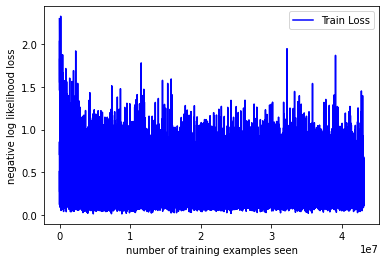

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


###Prediction on test data

In [ ]:
class testDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.data = img_file
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = np.expand_dims(np.squeeze(self.data[index]), axis = 2)
        # img = np.where(img >= 0.5, 1.0, 0.0)
        if self.transform is not None:
           img = self.transform(img)
        img = img.float()
        img = img.to(device)
        return img

In [ ]:
testData = testDataset(test_images, transform = image_transform)
test_set_loader = DataLoader(testData, batch_size = 10000, shuffle=False)

In [ ]:
print("Evaluate on test data")

network = Net()
network.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Project 3/model.pth'))
network.eval()
with torch.no_grad():
  for data in test_set_loader:
    output = network(data.cpu())
    results = output.data.max(1, keepdim=True)[1]

results = results.cpu()
results = np.squeeze(results.numpy())
print(np.shape(results))
dataframe = {'id':np.arange(len(results)),'class':results}
df = pd.DataFrame(dataframe)
df.to_csv('results.csv',index=False)

Evaluate on test data
(10000,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 48000, shuffle=True)

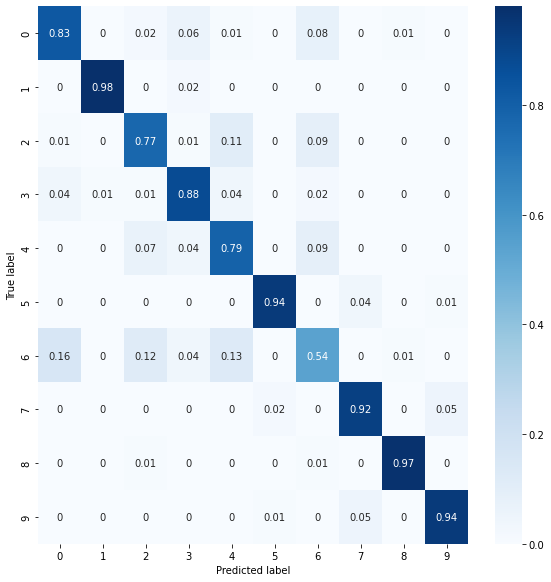

In [ ]:
# Confusion matrix

# network = Net()
# network.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Project 3/model1.pth'))
# network.eval()
# with torch.no_grad():
#   for data, label in train_loader:
#     output = network(data.cpu())
#     labels = label
#     results = output.data.max(1, keepdim=True)[1]

classes = [0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=labels.cpu(), predictions=results.cpu(), num_classes=10).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()